In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_regression
from sklearn.utils import resample
import matplotlib.pyplot as plt

In [2]:
np.random.seed(42)
X, y, coef = make_regression(
    n_samples=300,
    n_features=10,
    n_informative=3,   # Only 3 features truly matter
    noise=15.0,
    coef=True
)

In [3]:
feature_names = [f"Feature_{i}" for i in range(X.shape[1])]

In [ ]:
def forward_stagewise(X, y, max_features=None):
    """
    Greedy forward feature selection using simple linear regression.
    """
    n_samples, n_features = X.shape
    remaining_features = list(range(n_features))
    selected_features = []
    current_score = -np.inf
    best_new_score = -np.inf
    
    while remaining_features and (max_features is None or len(selected_features) < max_features):
        scores = []
        for feature in remaining_features:
            model = LinearRegression().fit(X[:, selected_features + [feature]], y)
            score = model.score(X[:, selected_features + [feature]], y)
            scores.append((score, feature))
        
        scores.sort(reverse=True)
        best_new_score, best_feature = scores[0]
        
        if best_new_score > current_score:
            remaining_features.remove(best_feature)
            selected_features.append(best_feature)
            current_score = best_new_score
        else:
            break
    
    return selected_features


def stability_selection(X, y, n_bootstrap=100, sample_fraction=0.75, max_features=None):
    """
    Run forward selection multiple times on resampled datasets
    and track how often each feature is selected.
    """
    n_samples = X.shape[0]
    selection_counts = np.zeros(X.shape[1])
    
    for i in range(n_bootstrap):
        X_resampled, y_resampled = resample(
            X, y,
            n_samples=int(sample_fraction * n_samples),
            random_state=i
        )
        selected = forward_stagewise(X_resampled, y_resampled, max_features)
        selection_counts[selected] += 1
    
    selection_freq = selection_counts / n_bootstrap
    return selection_freq


In [5]:
selection_freq = stability_selection(X, y, n_bootstrap=100, sample_fraction=0.75, max_features=5)


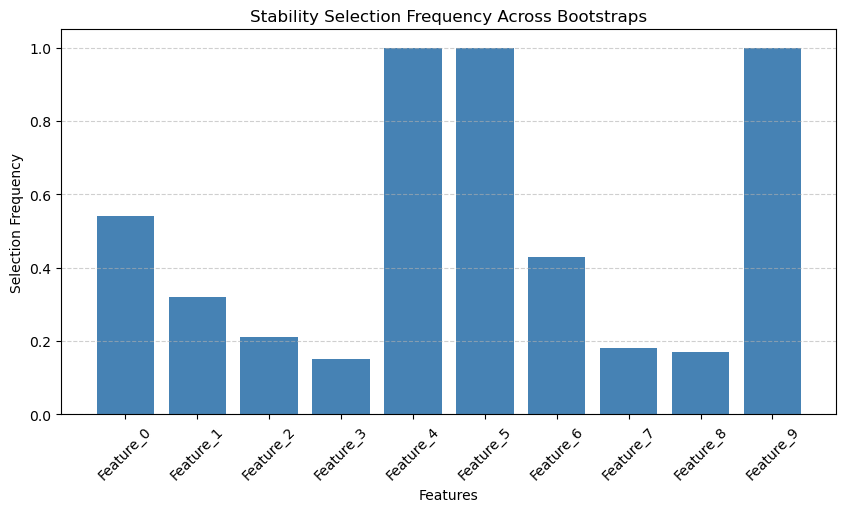

In [6]:
plt.figure(figsize=(10, 5))
plt.bar(feature_names, selection_freq, color="steelblue")
plt.xlabel("Features")
plt.ylabel("Selection Frequency")
plt.title("Stability Selection Frequency Across Bootstraps")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


In [7]:
df = pd.DataFrame({
    "Feature": feature_names,
    "Selection Frequency": selection_freq
}).sort_values("Selection Frequency", ascending=False)

print("\n=== Feature Selection Stability Results ===")
print(df.to_string(index=False))


=== Feature Selection Stability Results ===
  Feature  Selection Frequency
Feature_4                 1.00
Feature_5                 1.00
Feature_9                 1.00
Feature_0                 0.54
Feature_6                 0.43
Feature_1                 0.32
Feature_2                 0.21
Feature_7                 0.18
Feature_8                 0.17
Feature_3                 0.15
